In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

( train_ds , test_ds ) , ds_info = tfds.load ('mnist', split =[ 'train', 'test'], as_supervised = True , with_info = True )

In [36]:
def prepare_mnist_data(data):
    #flatten images to vectors
    data = data.map(lambda x, t: (tf.reshape(x, (-1,)), t))
    #convert data from uint8 to float32
    data = data.map(lambda x, t: (tf.cast(x, tf.float32), t))
    #normalize the data to values from -1 to 1
    data = data.map(lambda x, t: ((x / 128) -1, t))
    #convert targets to one hot vector
    data = data.map(lambda x, t: (x, tf.one_hot(t, depth = 10)))
    #cache progress
    data = data.cache()
    #shuffle, batch, prefetch
    data = data.shuffle(1000)
    data = data.batch(32)
    data = data.prefetch(20)
    return data

train_dataset = prepare_mnist_data(train_ds)
test_dataset = test_ds.apply(prepare_mnist_data)

In [37]:
print(train_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [38]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation = tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation = tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation = tf.nn.softmax)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [39]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
    
    return test_loss, test_accuracy

In [40]:
tf.keras.backend.clear_session()

num_epochs = 10
learning_rate = 0.1

model = MyModel()

cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate)

train_losses = []
test_losses = []
test_accuracies = []

test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

for epoch in range(num_epochs):
    print(f'Epoch:{str(epoch)} starting with accuracy {test_accuracies[-1]}')
    
    epoch_loss_aggregator = []
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_aggregator.append(train_loss)
    
    train_losses.append(tf.reduce_mean(epoch_loss_aggregator))
    
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch:0 starting with accuracy 0.08416533546325879
Epoch:1 starting with accuracy 0.950379392971246
Epoch:2 starting with accuracy 0.9675519169329073
Epoch:3 starting with accuracy 0.9722444089456869
Epoch:4 starting with accuracy 0.9732428115015974
Epoch:5 starting with accuracy 0.9749400958466453
Epoch:6 starting with accuracy 0.9753394568690096
Epoch:7 starting with accuracy 0.9785343450479234
Epoch:8 starting with accuracy 0.9708466453674122
Epoch:9 starting with accuracy 0.9800319488817891


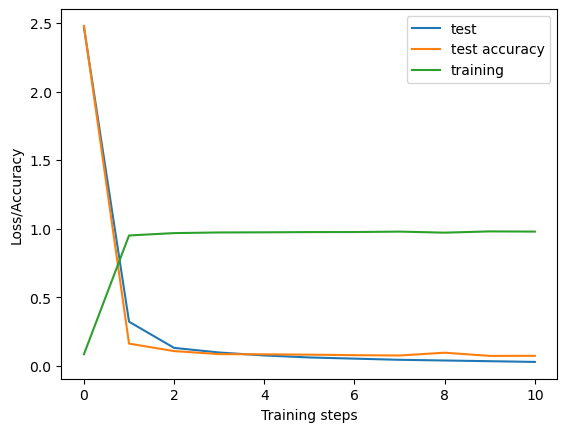

In [41]:
import matplotlib.pyplot as plt

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel('Training steps')
plt.ylabel('Loss/Accuracy')
plt.legend((line1,line2,line3), {'training', 'test', 'test accuracy'})
plt.show()